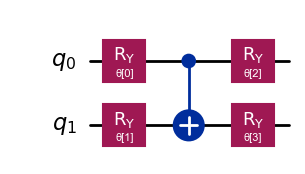

In [1]:
import numpy as np
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw()

In [19]:
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Pauli, SparsePauliOp
Z = Pauli('Z')
hamiltonian = Z ^ Z
#OR hamiltonian = SparsePauliOp('XX')
sparse_hamiltonian = SparsePauliOp('ZZ')
print(sparse_hamiltonian.to_matrix())

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [199]:
from qiskit.primitives import Sampler, Estimator

estimator = Estimator()
parameter_values = np.random.rand(ansatz.num_parameters)
print(f'parameters{parameter_values}')
expectation_value = estimator.run(circuits=ansatz, 
                                  observables=sparse_hamiltonian,
                                  parameter_values=parameter_values,
                                  seed=255, shots=1000000)
print(expectation_value.result().values.real)

def expectation_value(theta):
    result = estimator.run(circuits=ansatz, observables=sparse_hamiltonian,
                           parameter_values=theta,shots=1000000)
    return result.result().values.real[0]

print(expectation_value(parameter_values))

parameters[0.01927891 0.34289572 0.36248406 0.40690134]
[0.68755143]
0.6863009537002388


In [56]:
import numpy as np
point = np.random.random(ansatz.num_parameters)
INDEX = 2
print('point', point)


point [0.88742074 0.81729764 0.73346306 0.55908622]


In [110]:
from qiskit_algorithms.gradients import SPSAEstimatorGradient

EPS = 0.2

e_i = np.identity(point.size)[:,INDEX]
plus = point + EPS * e_i
minus = point - EPS * e_i

finite_different = (
    expectation_value(plus) - expectation_value(minus)) / (2 * EPS)
print(finite_different)
print(expectation_value(point))

[0.00038396]
[0.55118552]


In [182]:
k = 0.01
for i in range(10000):
    e_i = np.identity(point.size)[:,INDEX]
    plus = point + EPS * e_i
    minus = point - EPS * e_i

    finite_different = (
                        expectation_value(plus) - expectation_value(minus)
                        ) / (2 * EPS)
    point -= k * finite_different
print(expectation_value(point))

[0.55041009]


In [112]:
from scipy.sparse.linalg import eigs

hamiltonian_matrix = sparse_hamiltonian.to_matrix()
# Compute the eigenvalues and eigenvectors using scipy


[-1. -1.  1.  1.] [[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [152]:
from qiskit_algorithms.gradients import SPSAEstimatorGradient
from qiskit_algorithms import AlgorithmJob
from qiskit_algorithms.gradients import BaseEstimatorGradient
#base = BaseEstimatorGradient(estimator)
#base.run()
spsa_gradient = SPSAEstimatorGradient(estimator,epsilon=0.001, seed=1000)
params = [{param:value for param, value in zip(ansatz.parameters, point)}]
print(expectation_value(point))
job = spsa_gradient.run(circuits=ansatz, observables=sparse_hamiltonian,
                  parameter_values=params)


[0.55161618]
JobStatus.ERROR


In [163]:
EPS = np.pi / 2
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    expectation_value(plus) - expectation_value(minus)) / 2

print(finite_difference)

[0.0001184]


In [169]:
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

sampler = Sampler()
shift_estimator = ParamShiftEstimatorGradient(estimator=estimator)
job = shift_estimator.run(circuits=ansatz, observables=sparse_hamiltonian,parameter_values = params)
job.status()


<JobStatus.ERROR: 'job incurred error'>

In [202]:
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])
print(initial_point)
print(expectation_value(initial_point))

[0.43253681 0.09507794 0.42805949 0.34210341]
0.8837497267164455


In [216]:
from qiskit_algorithms.optimizers import GradientDescent
# Expectation value function  
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_log.update)

res = gd.minimize(fun=expectation_value,x0=initial_point)

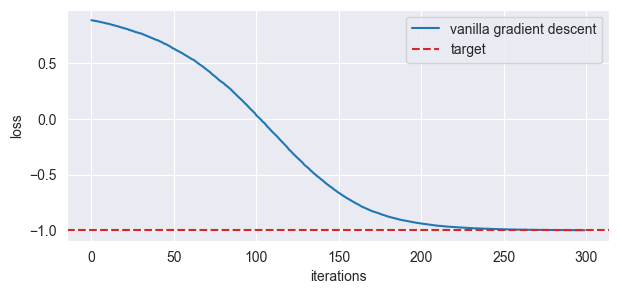

In [205]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

In [214]:
res.x
print(expectation_value(res.x))

-0.9981461149540904


In [195]:
from qiskit_algorithms.optimizers import GradientDescent
 
def f(x):
    return (np.linalg.norm(x) - 1) ** 2
 
initial_point = np.array([1, 0.5, -0.2])
print(f(initial_point))
optimizer = GradientDescent(maxiter=100)
 
result = optimizer.minimize(fun=f, x0=initial_point)
 
print(f"Found minimum {result.x} at a value"
    "of {result.fun} using {result.nfev} evaluations.")

0.01843666167989053
Found minimum [ 0.89239325  0.44769176 -0.18077331] at a valueof {result.fun} using {result.nfev} evaluations.


In [215]:
from qiskit_aer import Aer



SyntaxError: invalid syntax (462334855.py, line 1)

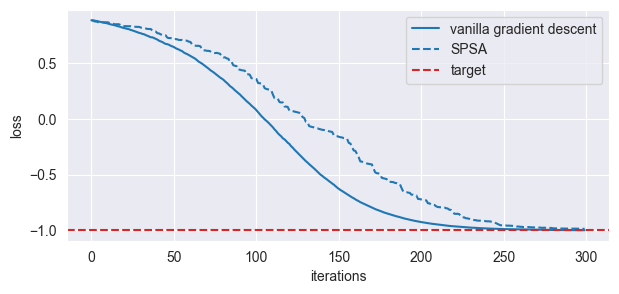

In [217]:
from qiskit_algorithms.optimizers import SPSA

spsa_log = OptimizerLog()
spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_log.update)

result = spsa.minimize(fun=expectation_value,x0=initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

In [234]:
from qiskit_algorithms.optimizers import QNSPSA
from qiskit.circuit.library import PauliTwoDesign

qnspsa_log = OptimizerLog()
fidelity = QNSPSA.get_fidelity(circuit=ansatz,sampler=sampler)
qnspsa = QNSPSA(fidelity=fidelity,
                maxiter=300, learning_rate=0.01,
                perturbation=0.01, callback=spsa_log.update)
result = qnspsa.minimize(fun=expectation_value,x0=initial_point)
print(f"Found minimum {result.x} at a value {expectation_value(result.x)}")

Found minimum [-0.02251367  0.72029577  0.01513202  2.42140151] at a value -0.999999808580874


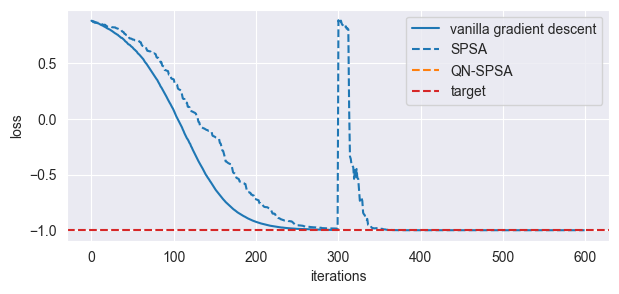

In [230]:
# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

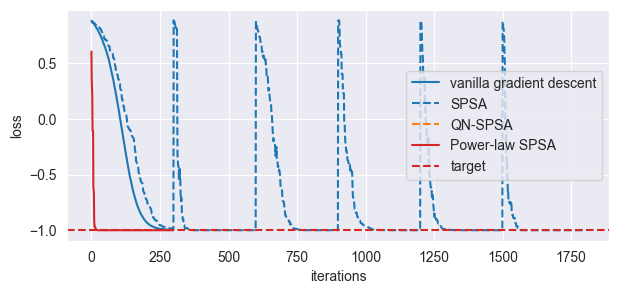

In [235]:
autospsa_log = OptimizerLog()
autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_log.update)

result = autospsa.minimize(expectation_value, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_log.loss, 'C3', label='Power-law SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

In [307]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_algorithms.gradients import SPSAEstimatorGradient
Z = Pauli('Z')
I = Pauli('I')

def sample_gradients(num_qubits, reps, local=False):
    
    index= num_qubits - 1
    
    if local:
        #operator = Z ^ Z ^(I ^ (num_qubits - 2))
        operator = Pauli('Z' * 2)
        for _ in range(num_qubits - 2):
            operator = operator ^ I
    else:
        operator = Pauli('Z' * num_qubits)
        
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)
    estimator = Estimator()
    param_shift_gradient = ParamShiftEstimatorGradient(estimator)
    
    num_points = 100
    grads = []
    
    for _ in range(num_points):
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        res = estimator.run(circuits=ansatz, 
                            observables=operator,
                            parameter_values=point)
        expectation = res.result().values.real[0]
        grad_res = param_shift_gradient.run(circuits=[ansatz],
                                            observables=[operator],
                                            parameter_values=[point],
                                            parameters=[[ansatz.parameters[index]]])
        grads.append(grad_res.result().gradients[0][0])
    
    return grads

In [300]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]


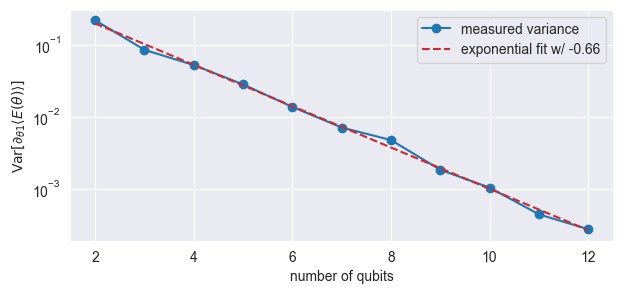

In [302]:
fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

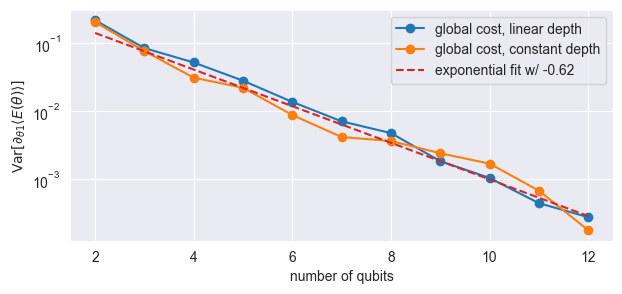

In [304]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]

fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients,
                                           axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-',
             label='global cost, constant depth')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

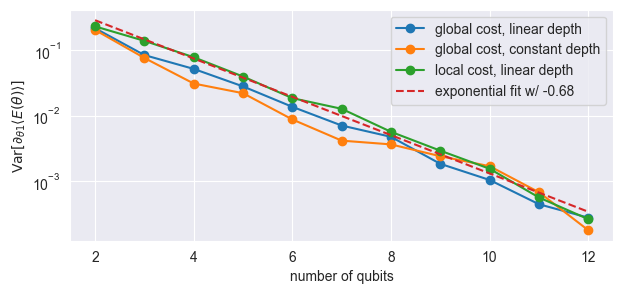

In [308]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n,
                                        local=True) for n in num_qubits]
fit = np.polyfit(num_qubits,
                 np.log(np.var(linear_depth_local_gradients,axis=1)),
                 deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1),
             'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1),
             'o-', label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

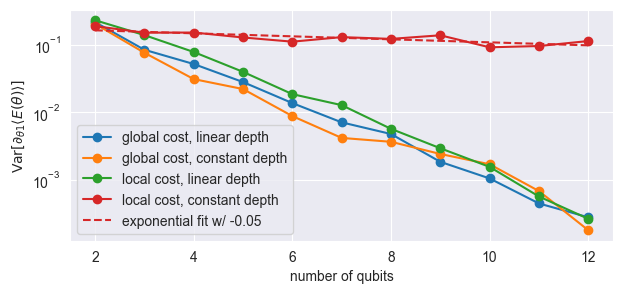

In [309]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1,
                                        local=True) for n in num_qubits]

fit = np.polyfit(num_qubits,
                 np.log(np.var(fixed_depth_local_gradients, axis=1)),
                 deg=1)

x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1),
             'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1),
             'o-', label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1),
             'o-', label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

In [332]:
NUM_QUBITS = 6
OPERATOR = Pauli('Z' * 2)
for _ in range(NUM_QUBITS - 4):
    OPERATOR = OPERATOR ^ I
def minimize(circuit, optimizer):
    """
    Args:
        circuit (QuantumCircuit): (Partially bound) ansatz circuit to train
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        OptimizerResult: Result of minimization
    """
    initial_point = np.random.random(circuit.num_parameters)
    print(circuit.num_parameters)
    estimator = Estimator()
    def loss(theta):
        return estimator.run(circuits=circuit, observables=OPERATOR,
                           parameter_values=theta).result().values.real[0]

    return optimizer.minimize(loss, initial_point)

def layerwise_training(ansatz, max_num_layers, optimizer):
    """
    Args:
        ansatz (QuantumCircuit): Single circuit layer to train & repeat
        max_num_layers (int): Maximum number of layers
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        float: Lowest value acheived
        list[float]: Best parameters found
    """
    optimal_parameters = []
    for reps in range(max_num_layers):
        ansatz.reps = reps
        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        #partially_bound = ansatz.bind_parameters(values_dict)
        partially_bound = ansatz.assign_parameters(values_dict)
        result = minimize(partially_bound, optimizer)
        optimal_parameters += list(result.x)
        print('Layer:', reps, ' Best Value:', result.fun)
    return result.fun, optimal_parameters

ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

np.random.seed(12)  # for reproducibility
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)
print(optimal_parameters)

4
Layer: 0  Best Value: 0.6257366714733875
4
Layer: 1  Best Value: 0.25645012894960795
4
Layer: 2  Best Value: -0.1354754657609362
4
Layer: 3  Best Value: -0.5555945396024742
[0.1541628423796697, 0.740049696515406, 0.3881509093442729, 0.8284402678629595, 0.01457496248542034, 0.9187470080998837, 1.1826869944277196, 0.003811397865033983, 0.9569493362751159, 0.13720932135607772, -0.044570738030107, 0.9066984520237126, 0.9442251360530419, 0.8527355411092828, -0.10878750952175364, 0.4536897066546731]
